### Imports

In [193]:
import pandas as pd
import numpy as np
import snscrape.modules.twitter as sntwitter
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from scipy.special import softmax
import torch
import re
import plotnine as p9

### Twitter scraping

In [194]:
query = '"prop 30"  until:2022-11-08 since:2022-07-01'
tweets = []
limit = 5000

In [195]:
for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    if len(tweets) == limit:
        break
    tweet_data = [tweet.date, tweet.user.username, tweet.content, tweet.likeCount, tweet.retweetCount]
    tweets.append(tweet_data)

In [196]:
tweets_df = pd.DataFrame(tweets, columns = ['Date', 'User', 'Content', 'Likes', 'Retweets'])

In [197]:
tweets_df

,Date,User,Content,Likes,Retweets
0,2022-11-07 23:01:03+00:00,YousefBaig,"Newsom claimed Prop. 30 ""puts corporate welfar...",1,4
1,2022-11-07 22:59:20+00:00,ClimateResolve,#Prop30 is pivotal to help our state combat da...,5,6
2,2022-11-07 22:56:18+00:00,trader_mtg,@ecommerceshares Wait until Prop 30 gets shot ...,1,0
3,2022-11-07 22:47:35+00:00,LByock,@dhere I voted no on 27 (which is in conflict ...,1,1
4,2022-11-07 22:39:45+00:00,SFBayPSR,"VOTE YES on Prop 30! If we don’t act, Californ...",10,7
...,...,...,...,...,...
2693,2022-07-02 01:01:34+00:00,alfred_twu,Prop 30: Electric Vehicles &amp; Wildfire Prev...,22,2
2694,2022-07-01 22:57:49+00:00,wickedmitch_,Tentative votes:\nProp 1: yes\nProp 26: yes\nP...,0,0
2695,2022-07-01 21:49:09+00:00,davidaguilar92,California's Secretary of State just released ...,0,0
2696,2022-07-01 20:22:45+00:00,RL_Miller,"Prop 1: OH HELL YES\nProp 26: Maybe, but not w...",1,0


### Data Preprocessing

In [198]:
def preprocess(text: str) -> str:
    '''
    Performs basic preprocessing on text to meet specifications of roBERTa model.
    References to other users ('@user123') will be replaced with '@user'.
    Any links ('https://www.google.com/') will be replaced with 'http'
    '''
    elements = []
    for element in text.split(' '):
        if element.startswith('@') and len(element) > 1:
            element = '@user'
        elif element.startswith('http'):
            element = 'hhtp'
        elements.append(element)
    return ' '.join(elements)

### Load in roBERTa model

Model found here:
https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest?text=Covid+cases+are+increasing+fast%21

In [199]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Perform sentiment analysis

In [200]:
def roberta(text: str):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    labels = config.id2label.values()
    scores_dict = dict(zip(labels, scores))
    return scores_dict

In [201]:
def get_sentiment(scores):
    sentiment = max(scores, key = scores.get)
    return sentiment

In [202]:
def sentiment_analysis(text:str):
    '''
    First checks if tweet contains various phrases that result in a trivial sentiment determination.
    Otherwise, performs roBERTa sentiment analysis.
    Returns a string defining the sentiment: 'Negative', 'Neutral', or 'Positive'.
    Also returns a numpy array containing the probabilities of each sentiment.
    For our analysis, Yes = 'Positive' and No = 'Negative'.
    '''
    positive_regex = 'yeson.{0,5}(prop)?.?30|prop.?30.?yes'
    negative_regex = 'noon.{0,5}(prop)?.?30|prop.?30.?no'

    lower_text = text.lower()
    # contains positive phrases
    if bool(re.search(positive_regex, lower_text.replace(' ',''))):
        sentiment_scores = {'Negative': 0, 'Neutral': 0, 'Positive': 1, 'Sentiment': 'Positive'}
    # contains negative phrases
    elif bool(re.search(negative_regex, lower_text.lower().replace(' ',''))):
        sentiment_scores = {'Negative': 1, 'Neutral': 0, 'Positive': 0, 'Sentiment': 'Negative'}
    else:
        sentiment_scores = roberta(text)
        sentiment = get_sentiment(sentiment_scores)
        sentiment_scores['Sentiment'] = sentiment
    return sentiment_scores

#### Run sentiment analysis on all tweets

In [222]:
results = []
for index, row in tweets_df.iterrows():
    sentiment_scores = sentiment_analysis(row['Content'])
    results.append((sentiment_scores))
sentiment_df = pd.DataFrame(results)
sentiment_df

,Negative,Neutral,Positive,Sentiment
0,0.699022,0.268416,0.032562,Negative
1,0.000000,0.000000,1.000000,Positive
2,0.767167,0.220800,0.012033,Negative
3,0.000000,0.000000,1.000000,Positive
4,0.000000,0.000000,1.000000,Positive
...,...,...,...,...
2693,0.057230,0.804284,0.138487,Neutral
2694,0.000000,0.000000,1.000000,Positive
2695,0.120726,0.858503,0.020771,Neutral
2696,0.143333,0.739530,0.117137,Neutral


#### Merge tweets_df and sentiment_df

In [224]:
sa_df = pd.concat([tweets_df, sentiment_df], axis=1)
sa_df

,Date,User,Content,Likes,Retweets,Negative,Neutral,Positive,Sentiment
0,2022-11-07 23:01:03+00:00,YousefBaig,"Newsom claimed Prop. 30 ""puts corporate welfar...",1,4,0.699022,0.268416,0.032562,Negative
1,2022-11-07 22:59:20+00:00,ClimateResolve,#Prop30 is pivotal to help our state combat da...,5,6,0.000000,0.000000,1.000000,Positive
2,2022-11-07 22:56:18+00:00,trader_mtg,@ecommerceshares Wait until Prop 30 gets shot ...,1,0,0.767167,0.220800,0.012033,Negative
3,2022-11-07 22:47:35+00:00,LByock,@dhere I voted no on 27 (which is in conflict ...,1,1,0.000000,0.000000,1.000000,Positive
4,2022-11-07 22:39:45+00:00,SFBayPSR,"VOTE YES on Prop 30! If we don’t act, Californ...",10,7,0.000000,0.000000,1.000000,Positive
...,...,...,...,...,...,...,...,...,...
2693,2022-07-02 01:01:34+00:00,alfred_twu,Prop 30: Electric Vehicles &amp; Wildfire Prev...,22,2,0.057230,0.804284,0.138487,Neutral
2694,2022-07-01 22:57:49+00:00,wickedmitch_,Tentative votes:\nProp 1: yes\nProp 26: yes\nP...,0,0,0.000000,0.000000,1.000000,Positive
2695,2022-07-01 21:49:09+00:00,davidaguilar92,California's Secretary of State just released ...,0,0,0.120726,0.858503,0.020771,Neutral
2696,2022-07-01 20:22:45+00:00,RL_Miller,"Prop 1: OH HELL YES\nProp 26: Maybe, but not w...",1,0,0.143333,0.739530,0.117137,Neutral


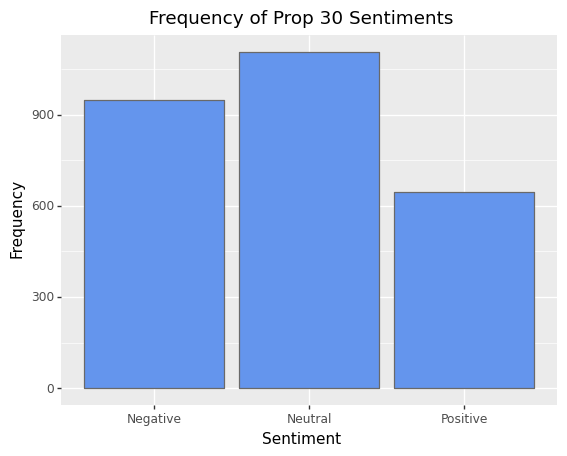

<ggplot: (127237474821)>

In [231]:
(
    p9.ggplot(data = sa_df, mapping = p9.aes(x = 'Sentiment'))
    + p9.geom_bar(color = 'dimgray', fill = 'cornflowerblue')
    +p9.labs(title = 'Frequency of Prop 30 Sentiments', y = 'Frequency')
)